In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import scipy
from sklearn.model_selection import KFold
import time
from scipy.stats import multivariate_normal
from scipy.linalg import fractional_matrix_power
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

##**Problem #1**

Fisher's LDA works by reducing the dimensions of the data and maximizing the variance between each class while minimizing the variance within each class. This can be thought of as transforming the data onto a new axis and then compressing each class and pushing them as far away from each other as possible.

In [39]:
class FLDA:
    def fit(self, data, label):
      # Copy the X and Y data for reduction of errors
      X = data.copy()
      Y = label.copy()

      n = X.shape[0]

      # For FLDA we only have 2 classes
      uniqueY = 2

      # Find the size of each data point
      features = X.shape[1]

      # Finds the means of each class (2x2)
      meanVec = []
      for i in range(0, 2):
        meanVec.append(np.mean(X[Y==i], axis = 0))

      # Initilizes the within class scatter matrix
      self.SW = np.zeros([features, features])
      # Loops through X and meanVec by class (0 or 1) and calculates the scatter
      # Zip the Y classes and meanVec together so that we can use the meanVec 
      # As a 2x1 and at the same time use the classes of X to generate the scatter at each point within the matrix
      for i, mv in zip(range(0,len(Y)), meanVec):
        classScat = np.zeros([features, features])
        for j in X[Y==i]:
          j, mv = j.reshape(features,1), mv.reshape(features,1)
          classScat += (j-mv).dot((j-mv).T)
        self.SW += classScat

      # Initilizes the Between class scatter matrix
      self.SB = np.zeros([features,features])

      # Calculates the overall means of X (1x2)
      mean = (np.mean(X, axis = 0))

      # Loops through meanVec to generate the Between class Scatter matrix
      for i, mv in enumerate(meanVec):
        mv, mean = mv.reshape(features,1), mean.reshape(features,1)
        self.SB += n * (mv-mean).dot((mv-mean).T)

      # Computes the weight matrix
      self.W = np.linalg.inv(self.SW) @ self.SB


    # Uses the weight matrix and the data to produce predicted outputs
    def predict(self, data):
      X = data.copy()
      x = np.atleast_2d(X).T
      
      # returns a matrix of 1 and 0
      return np.argmax((self.W@x).T, axis = 1)


Classification Report:

               precision    recall  f1-score   support

           0       0.99      0.76      0.86       255
           1       0.80      0.99      0.89       245

    accuracy                           0.87       500
   macro avg       0.89      0.88      0.87       500
weighted avg       0.90      0.87      0.87       500


Confusion Matrix:



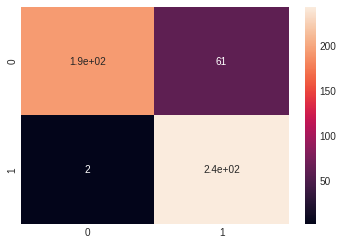

In [65]:
numberOfPoints = 1000

mean1 = np.array([-1, -1])
covariance1 = np.array([[5, 0], [0, 5]])
X1 = np.random.multivariate_normal(mean1, covariance1, numberOfPoints)

# generate points from class 1
mean2 = np.array([5, 5])
covariance2 = np.array([[5, 4], [4, 5]])
X2 = np.random.multivariate_normal(mean2, covariance2, numberOfPoints)

# stack the points
X = np.vstack((X1, X2))

# create a vector of the labels
Y = np.hstack((numberOfPoints * [0], numberOfPoints * [1]))

# randomly choose 75% of the data to be the training set and 25% for the testing set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)
# plot the training set
plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# fit the model to the training data
model = FLDA()
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)
# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

##**Problem #2**

Discriminant Analysis Nearest Neighbors works almost as a mixture of KNN and DA. When generating the scatter matrices it does not look at the entire data but deals with the scatter within the neighborhood and between the classes in the neighborhood. Then using DA it can find the regions where the classes are seperated. This is done by in according with DANN distances which search within an area around the test point and determines what most the neighbors are doing within that region (x0-x) * sigma * (x0-x).T

In [97]:
class DANN():
  def fit(self, X, Y, neighbors, epsilon):
    # Initilize variables used throughout the functions
    self.X = X
    self.Y = Y
    self.neighbors = neighbors
    self.epsilon = epsilon

  def predict(self, x, k):
    # search for unique classes
    uniqueY = np.unique(self.Y)

    # Set dimensional variables
    datapoints = self.X.shape[0]
    features = self.X.shape[1]

    distances = []
    # Loop through the each data point and find the determine the distances from each point
    for row in self.X:
      kdist = np.linalg.norm(x-row)
      distances.append(kdist)
    
    # Sort through the distances to find the nearest neighbors at each point
    indices = np.argsort(distances)[:self.neighbors]

    # Using those indeces determine the nearest X and Y neighbors
    nearest_neighbors = self.X[indices]
    nmean_x = np.mean(nearest_neighbors, axis = 0)
    neighbors_y = self.Y[indices]

    # Within the neighborhood find the number of classes
    classes = np.unique(neighbors_y)

    SW = np.zeros([features, features])
    SB = np.zeros([features, features])
    meanVec = []

    # Loop through each class to determine the within means
    for i in classes:
      meanVec.append(np.mean(nearest_neighbors[neighbors_y==i], axis = 0))
    
    # Generate the within class scatter matrix by looping through the class means and calculating covariance within the nearest neighbors
    for i, mv in zip(classes,meanVec):
      classScat = np.zeros([features, features])
      for j in nearest_neighbors[neighbors_y == i]:
        j, mv = j.reshape(features,1), mv.reshape(features,1)
        classScat += (1/datapoints)*(j-mv).dot((j-mv).T)
      SW += classScat
    
    # Next is to find the between scatter matrix which is used by comparing the means of each class and the overall means
    for i, mv in enumerate(meanVec):
      mv, nmean_x = mv.reshape(features,1), nmean_x.reshape(features,1)
      SB += (1/datapoints) * (mv-nmean_x).dot((mv-nmean_x).T)

    # Variable assignment for determining sigma which will be used as the metric to calculate DANN distances
    W = np.linalg.pinv(np.nan_to_num(np.power(SW, -0.5)))
    B = np.dot(W, SB).dot(W)
    I = np.identity(features)
    sigma = W.dot(B + self.epsilon * I).dot(W)
    prediction = []

    # Loop through each row and calculate the DANN distance, then find the nearest 
    # k points and determine what most of the surrounding neighors are
    for row in self.X:
      distances = (self.X-row).dot(sigma).dot((self.X-row).T)
      nearest = distances.argsort()[:k]
      prediction.append(stats.mode(self.Y[nearest)[0][0][0])
    return prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in power



Classification Report:

               precision    recall  f1-score   support

           0       0.81      1.00      0.90       255
           1       0.99      0.76      0.86       245

    accuracy                           0.88       500
   macro avg       0.90      0.88      0.88       500
weighted avg       0.90      0.88      0.88       500


Confusion Matrix:



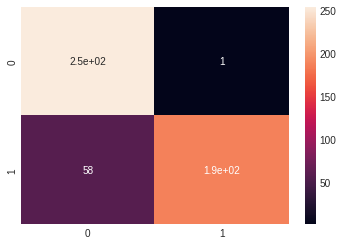

In [98]:
numberOfPoints = 1000

mean1 = np.array([-1, -1])
covariance1 = np.array([[5, 0], [0, 5]])
X1 = np.random.multivariate_normal(mean1, covariance1, numberOfPoints)

# generate points from class 1
mean2 = np.array([5, 5])
covariance2 = np.array([[5, 4], [4, 5]])
X2 = np.random.multivariate_normal(mean2, covariance2, numberOfPoints)

# stack the points
X = np.vstack((X1, X2))

# create a vector of the labels
Y = np.hstack((numberOfPoints * [0], numberOfPoints * [1]))

# randomly choose 75% of the data to be the training set and 25% for the testing set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)
# plot the training set
plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# fit the model to the training data
model = DANN()
#model.fit(trainX,trainY, 50, 1)
#model.predict(trainX)


# predict the labels of the test set
model.fit(testX,testY, 50, 1)
predictedY = model.predict(testX, 10)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

##**Problem #3**

After running all the different classifiers it seems that logistic regression and LDA perform with the highest accuracy without any tuning. Personally I would choose LDA because Logistic regression takes longer to compute than LDA. On average according to the k-fold validation, Logistic regression and DANN took the longest time to compute. These two classifiers will be used in problem #4


In [103]:
# List of all the headers
headers = ['Jitter (local)','Jitter (local, absolute)','Jitter (rap)',
           'Jitter (ppq5)','Jitter (ddp)','Shimmer (local)','Shimmer (local, dB)'
           ,'Shimmer (apq3)','Shimmer (apq5)','Shimmer (apq11)','Shimmer (dda)',
           'AC','NTH','HTN','Median pitch','Mean pitch','Standard deviation',
           'Minimum pitch','Maximum pitch','Number of pulses','Number of periods'
           ,'Mean period','Standard deviation of period',
           'Fraction of locally unvoiced frames',
           'Number of voice breaks','Degree of voice breaks','UPDRS','class information']
# List of trimmed headers, basically is headers without UPDRS 
headersT = ['Jitter (local)','Jitter (local, absolute)','Jitter (rap)',
           'Jitter (ppq5)','Jitter (ddp)','Shimmer (local)','Shimmer (local, dB)'
           ,'Shimmer (apq3)','Shimmer (apq5)','Shimmer (apq11)','Shimmer (dda)',
           'AC','NTH','HTN','Median pitch','Mean pitch','Standard deviation',
           'Minimum pitch','Maximum pitch','Number of pulses','Number of periods'
           ,'Mean period','Standard deviation of period',
           'Fraction of locally unvoiced frames',
           'Number of voice breaks','Degree of voice breaks','class information']
# Xhead removes UPRDS and class information
Xhead = ['Jitter (local)','Jitter (local, absolute)','Jitter (rap)',
           'Jitter (ppq5)','Jitter (ddp)','Shimmer (local)','Shimmer (local, dB)'
           ,'Shimmer (apq3)','Shimmer (apq5)','Shimmer (apq11)','Shimmer (dda)',
           'AC','NTH','HTN','Median pitch','Mean pitch','Standard deviation',
           'Minimum pitch','Maximum pitch','Number of pulses','Number of periods'
           ,'Mean period','Standard deviation of period',
           'Fraction of locally unvoiced frames',
           'Number of voice breaks','Degree of voice breaks']
# Yhead is solely the class information
Yhead = ['class information']

# Read the training file
dataTrain = pd.read_csv('train_data.txt', sep=",", names=headers, index_col=0)

# Drops UPDRS since it is not in the testing data
dataTrain.dropna(inplace=True)
dataTrain.reset_index(drop=True, inplace=True)
dataTrain = dataTrain.drop(columns = ['UPDRS'])
dataTest = pd.read_csv('test_data.txt', sep=',', names=headersT, index_col=0)


dataTest.dropna(inplace=True)
dataTest.reset_index(drop=True, inplace=True)

# These variables will be used in different problems throughout the homework
X = dataTrain[Xhead]
Y = dataTrain[Yhead]

Xtrain = dataTrain[Xhead]
Ytrain = dataTrain[Yhead]

Xtest = dataTest[Xhead]
Ytest = dataTest[Yhead]

















































































































































































































Finished in 0.43509888648986816 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.56      0.32      0.41        93
           1       0.59      0.79      0.68       115

    accuracy                           0.58       208
   macro avg       0.57      0.56      0.54       208
weighted avg       0.58      0.58      0.56       208


Confusion Matrix:



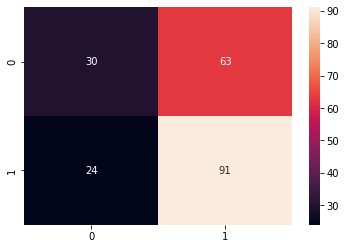



















































































































































































































Finished in 0.41561245918273926 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.25      0.36       112
           1       0.49      0.85      0.63        96

    accuracy                           0.53       208
   macro avg       0.58      0.55      0.49       208
weighted avg       0.59      0.53      0.48       208


Confusion Matrix:



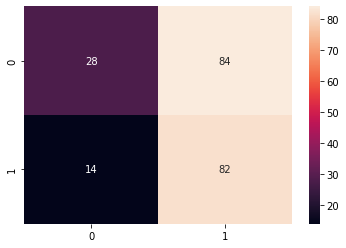



















































































































































































































Finished in 0.3940751552581787 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.63      0.37      0.47       100
           1       0.58      0.80      0.67       108

    accuracy                           0.59       208
   macro avg       0.60      0.58      0.57       208
weighted avg       0.60      0.59      0.57       208


Confusion Matrix:



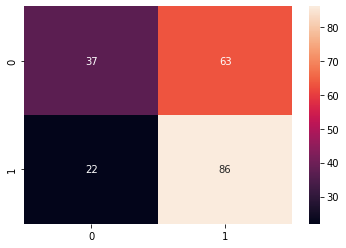



















































































































































































































Finished in 0.3876917362213135 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.59      0.28      0.38       105
           1       0.52      0.81      0.63       103

    accuracy                           0.54       208
   macro avg       0.56      0.54      0.51       208
weighted avg       0.56      0.54      0.50       208


Confusion Matrix:



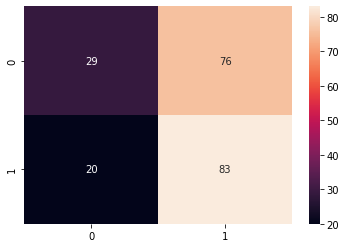



















































































































































































































Finished in 0.358736515045166 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.23      0.34       110
           1       0.50      0.88      0.64        98

    accuracy                           0.53       208
   macro avg       0.59      0.55      0.49       208
weighted avg       0.59      0.53      0.48       208


Confusion Matrix:



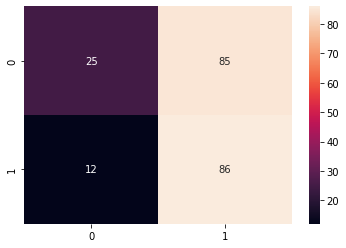




Averaged Accuracy:  0.5548076923076923

Average Time:  0.3982429504394531


In [42]:
class BayesClassifier:
    def fit(self, X, Y):     
        # find the unique labels
        uniqueY = np.unique(Y)
        
        # find the dimensions
        n = X.shape[0]
        self.d = X.shape[1]
        self.k = uniqueY.shape[0]
        
        # initialize the outputs
        self.prior = np.zeros([self.k, 1])
        self.mu = np.zeros([self.k, self.d])
        self.Sigma = np.zeros([self.k, self.d, self.d])
        
        # compute class prior probabilities, sample means, and sample covariances
        for i, y in enumerate(uniqueY):
            # split the X into its classes
            Xi = X[Y == y]
            
            # compute the size of each class
            ni = Xi.shape[0]
            
            # compute the priors
            self.prior[i] = ni / n
            
            # compute the sample mean
            self.mu[i] = np.mean(Xi, axis = 0)
            
            # compute the centered data
            XiBar = Xi - self.mu[i]
            
            # compute the sample covariance
            self.Sigma[i] = (1/ni) * XiBar.T @ XiBar
            
    def predict(self, X):
        n = X.shape[0]
        
        posteriorPre = np.zeros([n, self.k])
        
        # compute the pdf term of the posterior probabilities
        count = 0
        for i in X.iterrows():
            print()
            for j in range(self.k):
              posteriorPre[count][j] = scipy.stats.multivariate_normal.pdf(i[1], self.mu[j], self.Sigma[j], allow_singular = True)
            count +=1
                
        # compute a vector proportional to the posterior probabilities
        posterior = posteriorPre * self.prior.T

        # find the label for each datapoint by choosing the most probable class
        predictions = np.argmax(posterior, axis = 1)
        
        return predictions

kfold = KFold(5, shuffle = True, random_state = 1)
acc = []
at = []
for train, test in kfold.split(dataTrain):
  start = time.time()

  model = BayesClassifier()
  model.fit(dataTrain[Xhead].iloc[train], dataTrain[Yhead].iloc[train].values.reshape(-1,1).ravel())
  
  # predict the labels of the test set
  predictedY = model.predict(dataTrain[Xhead].iloc[test])
  end = time.time()
  print('Finished in', end - start, 'seconds')
  at.append(end-start)
  acc.append(accuracy_score(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)))
  # print quality metrics
  print('\nClassification Report:\n\n', classification_report(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)), annot = True) 
  plt.show()
  print("\n")  
print('\nAveraged Accuracy: ', np.mean(acc))
print('\nAverage Time: ', np.mean(at))

Finished in 0.00980830192565918 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.50      0.41      0.45        93
           1       0.58      0.67      0.62       115

    accuracy                           0.55       208
   macro avg       0.54      0.54      0.54       208
weighted avg       0.55      0.55      0.55       208


Confusion Matrix:



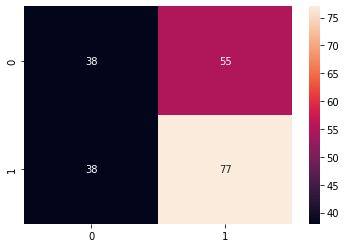



Finished in 0.008479833602905273 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.40      0.51       112
           1       0.54      0.81      0.65        96

    accuracy                           0.59       208
   macro avg       0.63      0.61      0.58       208
weighted avg       0.63      0.59      0.58       208


Confusion Matrix:



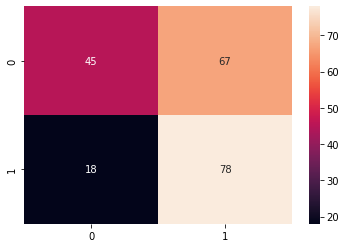



Finished in 0.008858203887939453 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.57      0.58      0.58       100
           1       0.61      0.60      0.60       108

    accuracy                           0.59       208
   macro avg       0.59      0.59      0.59       208
weighted avg       0.59      0.59      0.59       208


Confusion Matrix:



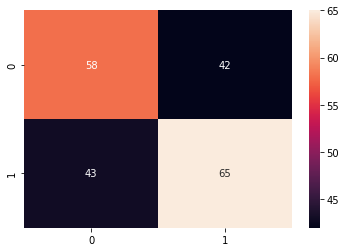



Finished in 0.008112668991088867 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.69      0.45      0.54       105
           1       0.59      0.80      0.67       103

    accuracy                           0.62       208
   macro avg       0.64      0.62      0.61       208
weighted avg       0.64      0.62      0.61       208


Confusion Matrix:



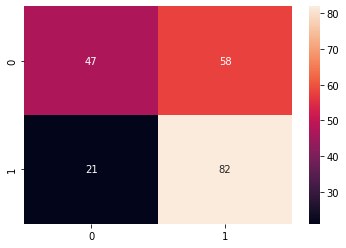



Finished in 0.008559465408325195 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.67      0.33      0.44       110
           1       0.52      0.82      0.63        98

    accuracy                           0.56       208
   macro avg       0.59      0.57      0.54       208
weighted avg       0.60      0.56      0.53       208


Confusion Matrix:



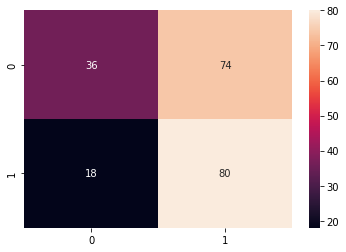




Averaged Accuracy:  0.5826923076923076

Average Time:  0.008763694763183593


In [43]:
kfold = KFold(5, shuffle = True, random_state = 1)
acc = []
at = []
for train, test in kfold.split(dataTrain):
  start = time.time()

  model = GaussianNB()
  model.fit(dataTrain[Xhead].iloc[train],dataTrain[Yhead].iloc[train].values.reshape(-1,1).ravel())
    # predict the labels of the test set
  predictedY = model.predict(dataTrain[Xhead].iloc[test])
  end = time.time()
  print('Finished in', end - start, 'seconds')
  at.append(end-start)
  acc.append(accuracy_score(dataTrain[Yhead].iloc[test].values.reshape(-1,1),predictedY.reshape(-1,1)))
  # print quality metrics
  print('\nClassification Report:\n\n', classification_report(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)), annot = True) 
  plt.show()
  print("\n")  
print('\nAveraged Accuracy: ', np.mean(acc))
print('\nAverage Time: ', np.mean(at))

Finished in 1.4384868144989014 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.56      0.65      0.60        93
           1       0.67      0.58      0.62       115

    accuracy                           0.61       208
   macro avg       0.61      0.61      0.61       208
weighted avg       0.62      0.61      0.61       208


Confusion Matrix:



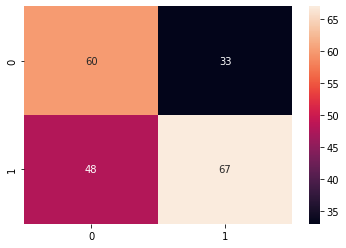



Finished in 1.9170091152191162 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.70      0.60      0.64       112
           1       0.60      0.70      0.64        96

    accuracy                           0.64       208
   macro avg       0.65      0.65      0.64       208
weighted avg       0.65      0.64      0.64       208


Confusion Matrix:



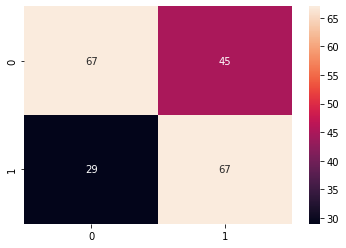



Finished in 1.524247169494629 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.67      0.64       100
           1       0.66      0.59      0.62       108

    accuracy                           0.63       208
   macro avg       0.63      0.63      0.63       208
weighted avg       0.63      0.63      0.63       208


Confusion Matrix:



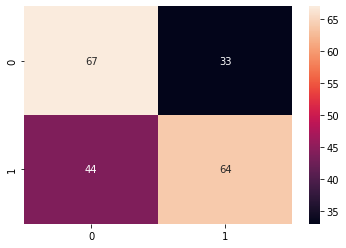



Finished in 2.051788568496704 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.56      0.58       105
           1       0.58      0.61      0.59       103

    accuracy                           0.59       208
   macro avg       0.59      0.59      0.59       208
weighted avg       0.59      0.59      0.59       208


Confusion Matrix:



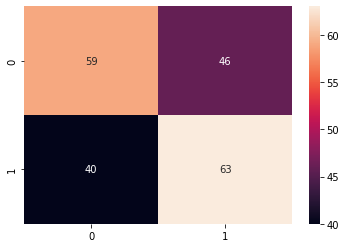



Finished in 1.7225463390350342 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.69      0.59      0.64       110
           1       0.61      0.70      0.65        98

    accuracy                           0.64       208
   macro avg       0.65      0.65      0.64       208
weighted avg       0.65      0.64      0.64       208


Confusion Matrix:



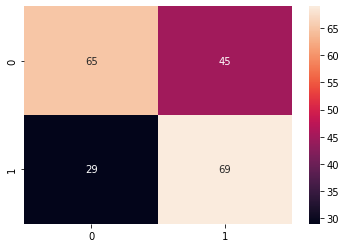




Averaged Accuracy:  0.6230769230769231

Average Time:  1.730815601348877


In [44]:
kfold = KFold(5, shuffle = True, random_state = 1)
acc = []
at = []
for train, test in kfold.split(dataTrain):
  temp = 0
  start = time.time()

  model = LogisticRegression(max_iter=10000)
  model.fit(dataTrain[Xhead].iloc[train],dataTrain[Yhead].iloc[train].values.reshape(-1,1).ravel())
  # predict the labels of the test set
  predictedY = model.predict(dataTrain[Xhead].iloc[test])
  end = time.time()
  print('Finished in', end - start, 'seconds')
  at.append(end-start)
  acc.append(accuracy_score(dataTrain[Yhead].iloc[test].values.reshape(-1,1),predictedY.reshape(-1,1)))
  print('\nClassification Report:\n\n', classification_report(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)), annot = True) 
  plt.show()
  print("\n")
print('\nAveraged Accuracy: ', np.mean(acc))
print('\nAverage Time: ', np.mean(at))

Finished in 0.06802248954772949 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.55      1.00      0.71       115

    accuracy                           0.55       208
   macro avg       0.28      0.50      0.36       208
weighted avg       0.31      0.55      0.39       208


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


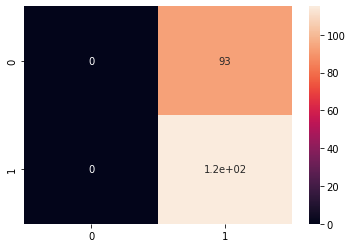



Finished in 0.07099652290344238 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.46      1.00      0.63        96

    accuracy                           0.46       208
   macro avg       0.23      0.50      0.32       208
weighted avg       0.21      0.46      0.29       208


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


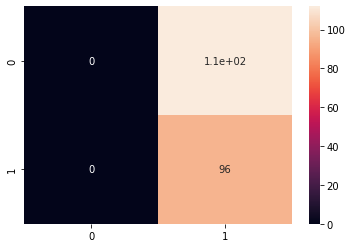



Finished in 0.07748794555664062 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.52      1.00      0.68       108

    accuracy                           0.52       208
   macro avg       0.26      0.50      0.34       208
weighted avg       0.27      0.52      0.35       208


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


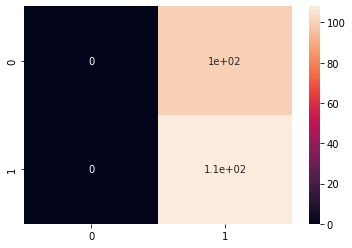



Finished in 0.0724952220916748 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.50      1.00      0.66       103

    accuracy                           0.50       208
   macro avg       0.25      0.50      0.33       208
weighted avg       0.25      0.50      0.33       208


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


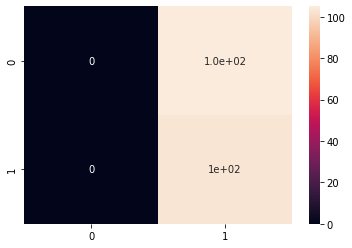



Finished in 0.08123898506164551 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.47      1.00      0.64        98

    accuracy                           0.47       208
   macro avg       0.24      0.50      0.32       208
weighted avg       0.22      0.47      0.30       208


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


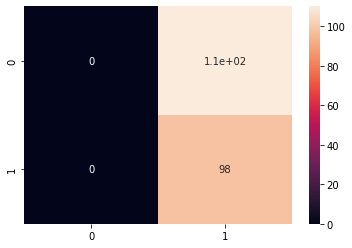




Averaged Accuracy:  0.5000000000000001

Average Time:  0.07404823303222656


In [45]:
# The previous fishers class was not suited to handle dataframes and 
# I was having issues converting dataframes into matrices so I made a new class 
# that was suited to resolve these issues (Basically just have different forms of looping through the data)
class TF:
    def fit(self, data, label):
      # Copy the X and Y data for reduction of errors
      X = data.copy()
      Y = label.copy()

      n = X.shape[0]

      # For FLDA we only have 2 classes
      uniqueY = 2

      # Find the size of each data point
      features = X.shape[1]

      # Finds the means of each class (2x2)
      meanVec = []
      for i in range(0, 2):
        meanVec.append(np.mean(X.iloc[X.index[Y['class information'] == i]], axis = 0))
      
      meanVec = np.array(meanVec)
      
        
      # Initilizes the within class scatter matrix
      self.SW = np.zeros([features, features])
      # Loops through X and meanVec by class (0 or 1) and calculates the scatter
      # Zip the Y classes and meanVec together so that we can use the meanVec 
      # As a 2x1 and at the same time use the classes of X to generate the scatter at each point within the matrix
      for i, mv in zip(range(0,len(Y)), meanVec):
        classScat = np.zeros([features, features])
        for index, j in X.iloc[X.index[Y['class information'] == i]].iterrows():
          j, mv = j.values.reshape(features,1), mv.reshape(features,1)
          mv = mv.reshape(-1,1)
          classScat += (j-mv).dot((j-mv).T)
        
        self.SW += classScat

      # Initilizes the Between class scatter matrix
      self.SB = np.zeros([features,features])

      # Calculates the overall means of X (1x2)
      mean = (np.mean(X, axis = 0))
      # Loops through meanVec to generate the Between class Scatter matrix
      for mv in meanVec:
          self.SB += n * (mv-mean).dot((mv-mean).T)

      # Computes the weight matrix
      self.W = np.linalg.inv(self.SW) @ self.SB


    # Uses the weight matrix and the data to produce predicted outputs
    def predict(self, data):
      X = data.copy()
      x = np.atleast_2d(X).T
      
      # returns a matrix of 1 and 0
      return np.argmax((self.W@x).T, axis = 1)


kfold = KFold(5, shuffle = True, random_state = 1)
acc = []
at = []
for train, test in kfold.split(dataTrain):
  start = time.time()

  model = TF()
  model.fit(Xtrain,Ytrain)
  # predict the labels of the test set
  predictedY = model.predict(dataTrain[Xhead].iloc[test])
  end = time.time()
  print('Finished in', end - start, 'seconds')
  at.append(end-start)
  acc.append(accuracy_score(dataTrain[Yhead].iloc[test].values.reshape(-1,1),predictedY.reshape(-1,1)))
  # print quality metrics
  print('\nClassification Report:\n\n', classification_report(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)), annot = True) 
  plt.show()
  print("\n")
print('\nAveraged Accuracy: ', np.mean(acc))
print('\nAverage Time: ', np.mean(at))

Finished in 0.026650190353393555 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.65      0.61        93
           1       0.68      0.62      0.65       115

    accuracy                           0.63       208
   macro avg       0.63      0.63      0.63       208
weighted avg       0.64      0.63      0.63       208


Confusion Matrix:



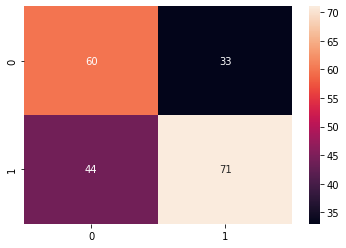



Finished in 0.013401508331298828 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.69      0.61      0.65       112
           1       0.60      0.69      0.64        96

    accuracy                           0.64       208
   macro avg       0.65      0.65      0.64       208
weighted avg       0.65      0.64      0.64       208


Confusion Matrix:



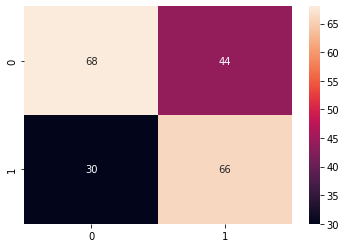



Finished in 0.015015125274658203 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.62      0.75      0.68       100
           1       0.71      0.57      0.64       108

    accuracy                           0.66       208
   macro avg       0.67      0.66      0.66       208
weighted avg       0.67      0.66      0.66       208


Confusion Matrix:



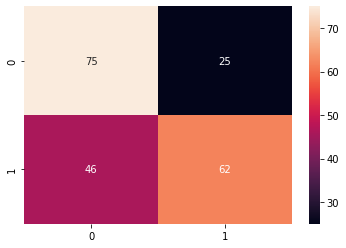



Finished in 0.012923479080200195 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.59      0.59       105
           1       0.58      0.57      0.58       103

    accuracy                           0.58       208
   macro avg       0.58      0.58      0.58       208
weighted avg       0.58      0.58      0.58       208


Confusion Matrix:



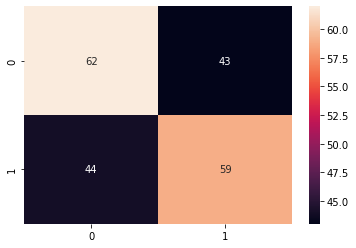



Finished in 0.012770891189575195 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.72      0.56      0.63       110
           1       0.61      0.76      0.67        98

    accuracy                           0.65       208
   macro avg       0.66      0.66      0.65       208
weighted avg       0.67      0.65      0.65       208


Confusion Matrix:



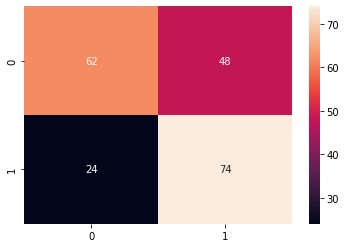




Averaged Accuracy:  0.6336538461538461

Average Time:  0.016152238845825194


In [46]:
kfold = KFold(5, shuffle = True, random_state = 1)
acc = []
at = []
for train, test in kfold.split(dataTrain):
  start = time.time()

  model = LinearDiscriminantAnalysis()
  model.fit(dataTrain[Xhead].iloc[train],dataTrain[Yhead].iloc[train].values.reshape(-1,1).ravel())
  # predict the labels of the test set
  predictedY = model.predict(dataTrain[Xhead].iloc[test])
  end = time.time()
  print('Finished in', end - start, 'seconds')
  at.append(end-start)
  acc.append(accuracy_score(dataTrain[Yhead].iloc[test].values.reshape(-1,1),predictedY.reshape(-1,1)))
  # print quality metrics
  print('\nClassification Report:\n\n', classification_report(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)), annot = True) 
  plt.show()
  print("\n")
print('\nAveraged Accuracy: ', np.mean(acc))
print('\nAverage Time: ', np.mean(at))

Finished in 0.016789674758911133 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.32      0.40        93
           1       0.59      0.77      0.67       115

    accuracy                           0.57       208
   macro avg       0.56      0.55      0.53       208
weighted avg       0.56      0.57      0.55       208


Confusion Matrix:



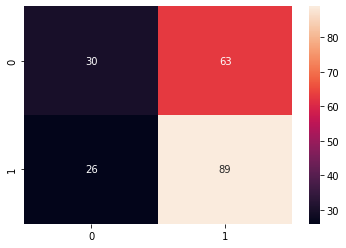



Finished in 0.015227079391479492 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.27      0.38       112
           1       0.50      0.85      0.63        96

    accuracy                           0.54       208
   macro avg       0.59      0.56      0.51       208
weighted avg       0.60      0.54      0.50       208


Confusion Matrix:



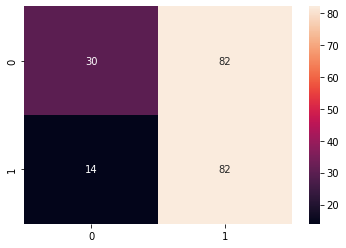



Finished in 0.014238834381103516 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.69      0.43      0.53       100
           1       0.61      0.82      0.70       108

    accuracy                           0.63       208
   macro avg       0.65      0.63      0.62       208
weighted avg       0.65      0.63      0.62       208


Confusion Matrix:



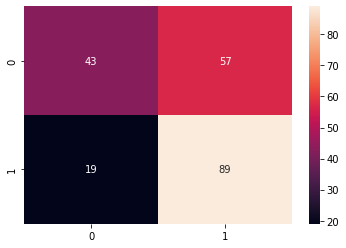



Finished in 0.014490365982055664 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.65      0.31      0.42       105
           1       0.54      0.83      0.65       103

    accuracy                           0.57       208
   macro avg       0.59      0.57      0.54       208
weighted avg       0.59      0.57      0.54       208


Confusion Matrix:



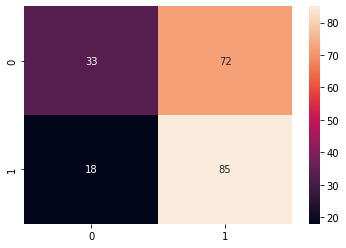



Finished in 0.014154672622680664 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.75      0.27      0.40       110
           1       0.52      0.90      0.66        98

    accuracy                           0.57       208
   macro avg       0.64      0.59      0.53       208
weighted avg       0.64      0.57      0.52       208


Confusion Matrix:



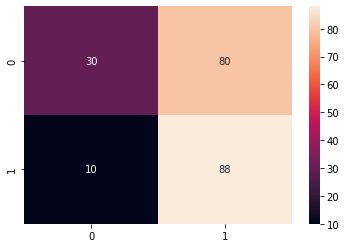




Averaged Accuracy:  0.5759615384615385

Average Time:  0.014980125427246093


In [47]:
kfold = KFold(5, shuffle = True, random_state = 1)
acc = []
at =[]
for train, test in kfold.split(dataTrain):
  start = time.time()

  model = QuadraticDiscriminantAnalysis()
  model.fit(dataTrain[Xhead].iloc[train],dataTrain[Yhead].iloc[train].values.reshape(-1,1).ravel())
  # predict the labels of the test set
  predictedY = model.predict(dataTrain[Xhead].iloc[test])
  end = time.time()
  print('Finished in', end - start, 'seconds')
  at.append(end-start)
  acc.append(accuracy_score(dataTrain[Yhead].iloc[test].values.reshape(-1,1),predictedY.reshape(-1,1)))
  # print quality metrics
  print('\nClassification Report:\n\n', classification_report(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)), annot = True) 
  plt.show()
  print("\n")
print('\nAveraged Accuracy: ', np.mean(acc))
print('\nAverage Time: ', np.mean(at))

Finished in 0.0037810802459716797 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.62      0.60        93
           1       0.68      0.63      0.65       115

    accuracy                           0.63       208
   macro avg       0.63      0.63      0.63       208
weighted avg       0.63      0.63      0.63       208


Confusion Matrix:



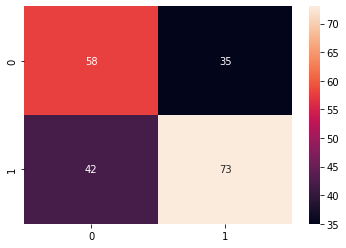



Finished in 0.006337165832519531 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.62      0.66       112
           1       0.61      0.71      0.66        96

    accuracy                           0.66       208
   macro avg       0.66      0.66      0.66       208
weighted avg       0.67      0.66      0.66       208


Confusion Matrix:



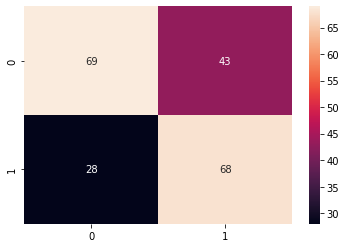



Finished in 0.005232334136962891 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.59      0.66      0.63       100
           1       0.65      0.58      0.61       108

    accuracy                           0.62       208
   macro avg       0.62      0.62      0.62       208
weighted avg       0.62      0.62      0.62       208


Confusion Matrix:



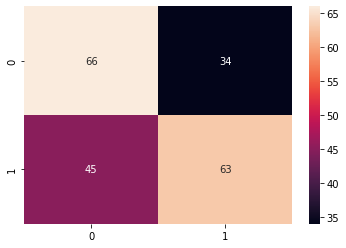



Finished in 0.00522303581237793 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.67      0.63       105
           1       0.62      0.54      0.58       103

    accuracy                           0.61       208
   macro avg       0.61      0.61      0.60       208
weighted avg       0.61      0.61      0.60       208


Confusion Matrix:



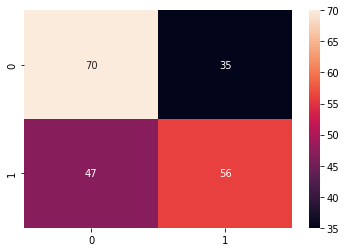



Finished in 0.005613088607788086 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.64      0.67      0.66       110
           1       0.61      0.58      0.60        98

    accuracy                           0.63       208
   macro avg       0.63      0.63      0.63       208
weighted avg       0.63      0.63      0.63       208


Confusion Matrix:



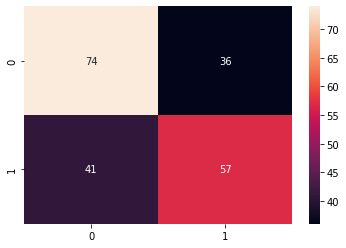




Averaged Accuracy:  0.6288461538461538

Average Time:  0.023803234100341797


In [48]:
kfold = KFold(5, shuffle = True, random_state = 1)
acc = []
at = []
for train, test in kfold.split(dataTrain):
  start = time.time()

  model = KNeighborsClassifier()
  model.fit(dataTrain[Xhead].iloc[train],dataTrain[Yhead].iloc[train].values.reshape(-1,1).ravel())
  end = time.time()
  print('Finished in', end - start, 'seconds')
  # predict the labels of the test set
  predictedY = model.predict(dataTrain[Xhead].iloc[test])
  end = time.time()
  at.append(end-start)
  acc.append(accuracy_score(dataTrain[Yhead].iloc[test].values.reshape(-1,1),predictedY.reshape(-1,1)))
  # print quality metrics
  print('\nClassification Report:\n\n', classification_report(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY.reshape(-1,1)), annot = True) 
  plt.show()
  print("\n")  
print('\nAveraged Accuracy: ', np.mean(acc))
print('\nAverage Time: ', np.mean(at))

Finished in 2.4126319885253906 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.57      0.73      0.64        93
           1       0.72      0.56      0.63       115

    accuracy                           0.63       208
   macro avg       0.65      0.64      0.63       208
weighted avg       0.65      0.63      0.63       208


Confusion Matrix:



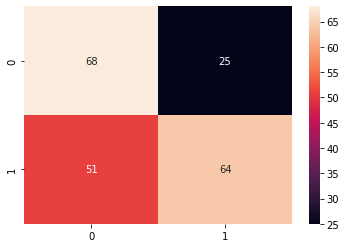



Finished in 2.4229540824890137 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.71      0.71      0.71       112
           1       0.66      0.66      0.66        96

    accuracy                           0.69       208
   macro avg       0.69      0.69      0.69       208
weighted avg       0.69      0.69      0.69       208


Confusion Matrix:



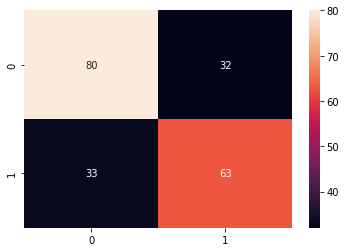



Finished in 2.4130594730377197 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.57      0.71      0.63       100
           1       0.65      0.50      0.57       108

    accuracy                           0.60       208
   macro avg       0.61      0.60      0.60       208
weighted avg       0.61      0.60      0.60       208


Confusion Matrix:



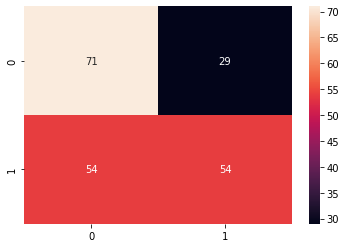



Finished in 2.388706922531128 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.71      0.64       105
           1       0.62      0.48      0.54       103

    accuracy                           0.60       208
   macro avg       0.60      0.60      0.59       208
weighted avg       0.60      0.60      0.59       208


Confusion Matrix:



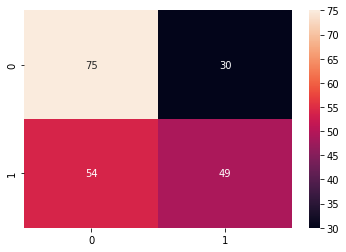



Finished in 2.426769733428955 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.63      0.70      0.66       110
           1       0.61      0.53      0.57        98

    accuracy                           0.62       208
   macro avg       0.62      0.62      0.61       208
weighted avg       0.62      0.62      0.62       208


Confusion Matrix:



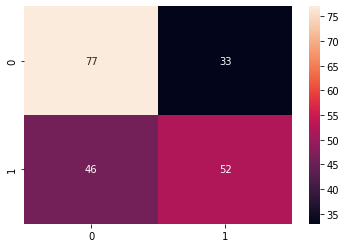




Averaged Accuracy:  0.6278846153846154

Average Time:  2.4128244400024412


In [49]:
# I had the same problem with DANN so I decided to make a new class
class DANN2():
  def fit(self, X, Y, neighbors, epsilon):
    self.X = X
    self.Y = Y
    self.neighbors = neighbors
    self.epsilon = epsilon

  def predict(self, x, k):
    uniqueY = np.unique(self.Y)
    datapoints = self.X.shape[0]
    features = self.X.shape[1]
    distances = []
    for index, row in self.X.iterrows():
      kdist = np.linalg.norm(x-row)
      indices = np.argsort(distances)[:self.neighbors]
      distances.append(kdist)
    nearest_neighbors = self.X.iloc[indices]
    nmean_x = np.mean(nearest_neighbors, axis = 0)
    nmean_x = nmean_x.values
    neighbors_y = self.Y.iloc[indices]
    classes = np.unique(neighbors_y)

    SW = np.zeros([features, features])
    SB = np.zeros([features, features])
    meanVec = []
    for i in classes:
      meanVec.append(np.mean(nearest_neighbors[neighbors_y==i], axis = 0))
    meanVec = np.array(meanVec)
    for i, mv in zip(classes,meanVec):
      classScat = np.zeros([features, features])
      #for index, j in X.iloc[X.index[Y['class information'] == i]].iterrows():
      for index, j in nearest_neighbors.loc[nearest_neighbors.index[neighbors_y['class information'] == i]].iterrows():
        j, mv = j.values.reshape(features,1), mv.reshape(features,1)
        classScat += (j-mv).dot((j-mv).T)
      SW += classScat
    
    for i, mv in enumerate(meanVec):
      mv, nmean_x = mv.reshape(features,1), nmean_x.reshape(features,1)
      SB += (1/datapoints) * (mv-nmean_x).dot((mv-nmean_x).T)


    W = np.linalg.pinv(np.nan_to_num(np.power(SW, -0.5)))
    B = np.dot(W, SB).dot(W)
    I = np.identity(features)
    sigma = W.dot(B + self.epsilon * I).dot(W)

    prediction = []
    for index, row in x.iterrows():
      distances = (x-row) @ sigma @ (x-row).T
      nearest = distances.argsort(kind = 'quicksort')[:k]
      prediction.append(stats.mode(self.Y.iloc[nearest])[0][0][0])
    return prediction


kfold = KFold(5, shuffle = True, random_state = 1)
acc = []
at = []
for train, test in kfold.split(dataTrain):
  start = time.time()

  model = DANN2()
  model.fit(dataTrain[Xhead].iloc[train],dataTrain[Yhead].iloc[train], 50, 1)
  # predict the labels of the test set
  predictedY = model.predict(dataTrain[Xhead].iloc[test], 10)
  end = time.time()
  print('Finished in', end - start, 'seconds')
  at.append(end-start)
  acc.append(accuracy_score(dataTrain[Yhead].iloc[test].values.reshape(-1,1),predictedY))
  # print quality metrics
  print('\nClassification Report:\n\n', classification_report(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(dataTrain[Yhead].iloc[test].values.reshape(-1,1), predictedY), annot = True) 
  plt.show()
  print("\n")  
print('\nAveraged Accuracy: ', np.mean(acc))
print('\nAverage Time: ', np.mean(at))

##**Problem #4**

The two classifiers that took the longest were DANN followed by logistic regression. After using PCA to reduce the dimensions and contain 90% of the variation, we were able to reduce the computational time significantly for logistic regression, going from 1.73 seconds on average down to 0.012 seconds. For DANN we were able to reduce the computation time from 2.42 seconds down to 2.04 seconds. Logistic Regression lost roughly 10 percent accuracy while DANN gained 7 percent accuracy.

In [113]:
def PCA(Xtrain, alpha):        
    # find the original dimension and print it
    dimension = Xtrain.shape[1]
    print('The original dimension of the data is', dimension)
    
    # center D to have mean 0
    Xtrain -= np.mean(Xtrain, axis=0)
    
    # compute the covariance matrix
    Sigma = (1/Xtrain.shape[0]) * Xtrain.T @ Xtrain

    # compute the eigenvalues and eigenvectors of D^T D
    (eValues, eVectors) = np.linalg.eigh(Sigma)

    # compute the total variance
    varX = np.sum(eValues)
    
    # initialize the variance for A to 0
    varA = 0.0
    
    # reverse eValues and eVectors
    eValues = np.flip(eValues)
    eVectors = np.flip(eVectors, axis=1)

    # find the minimum dimension consisting of fraction at least alpha of the total variance
    for r in np.arange(0, eValues.shape[0]):
        varA += eValues[r]
        ratio = varA/varX

        if ratio > alpha:
            dimension = r + 1
            print('The new dimension of the data is', dimension, 'and it explains', ratio, 'of the variance')
            break
            
    # construct the new basis
    basis = eVectors[:,:dimension]
    
    # create the datapoints in the new space
    A = Xtrain @ basis
    
    # return points
    return A

In [114]:
import time
start = time.time()

# Apply PCA to the data matrices
X = PCA(Xtrain, 0.9)

end = time.time()

print('PCA finished in', end - start, 'seconds')

The original dimension of the data is 26
The new dimension of the data is 2 and it explains 0.9081906893049387 of the variance
PCA finished in 0.006323099136352539 seconds


Finished in 2.0442047119140625 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.66      0.77      0.71       520
           1       0.72      0.61      0.66       520

    accuracy                           0.69      1040
   macro avg       0.69      0.69      0.68      1040
weighted avg       0.69      0.69      0.68      1040


Confusion Matrix:



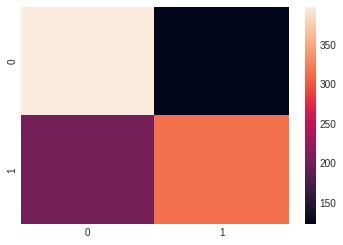

In [119]:
class DANN():
  def fit(self, X, Y, neighbors, epsilon):
    self.X = X
    self.Y = Y
    self.neighbors = neighbors
    self.epsilon = epsilon

  def predict(self, x, k):
    uniqueY = np.unique(self.Y)
    datapoints = self.X.shape[0]
    features = self.X.shape[1]
    distances = []
    for index, row in self.X.iterrows():
      kdist = np.linalg.norm(self.X-row)
      distances.append(kdist)
    indices = np.argsort(distances)[:self.neighbors]
    nearest_neighbors = self.X.iloc[indices]
    nmean_x = np.mean(nearest_neighbors, axis = 0)
    neighbors_y = self.Y.iloc[indices]
    classes = np.unique(neighbors_y)

    SW = np.zeros([features, features])
    SB = np.zeros([features, features])
    meanVec = []

    for i in classes:
      meanVec.append(np.mean(nearest_neighbors.iloc[np.where(neighbors_y == i)[0]], axis = 0))
    
    meanVec = np.array(meanVec)

    for i, mv in zip(classes,meanVec):
      classScat = np.zeros([features, features])
      for index, j in nearest_neighbors.iloc[np.where(neighbors_y == i)[0]].iterrows():
        j, mv = j.values.reshape(features,1), mv.reshape(features,1)
        classScat += (1/datapoints)*(j-mv).dot((j-mv).T)
      SW += classScat
    
    for i, mv in enumerate(meanVec):
      SB += (1/datapoints) * (mv-nmean_x).dot((mv-nmean_x).T)

    W = np.linalg.pinv(np.nan_to_num(np.power(SW, -0.5)))
    B = np.dot(W, SB).dot(W)
    I = np.identity(features)
    sigma = W.dot(B + self.epsilon * I).dot(W)
    prediction = []
    for index, row in self.X.iterrows():
      distances = (self.X-row).dot(sigma).dot((self.X-row).T)
      nearest = distances.argsort()[:k]
      prediction.append(stats.mode(self.Y.iloc[nearest])[0][0][0])
    return prediction

start = time.time()
model = DANN()
model.fit(X,Y, 50, 1)
# predict the labels of the test set
predictedY = model.predict(X, 10)
end = time.time()
print('Finished in', end - start, 'seconds')
# print quality metrics
print('\nClassification Report:\n\n', classification_report(Y,predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(Y,predictedY))
plt.show()
print("\n")   

Finished in 0.012037277221679688 seconds

Classification Report:

               precision    recall  f1-score   support

           0       0.56      0.45      0.50       520
           1       0.54      0.65      0.59       520

    accuracy                           0.55      1040
   macro avg       0.55      0.55      0.54      1040
weighted avg       0.55      0.55      0.54      1040


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


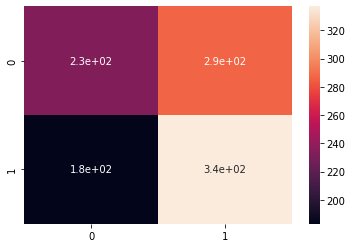

In [53]:
  start = time.time()
  model = LogisticRegression(max_iter=10000)
  model.fit(X,Y)
  # predict the labels of the test set
  predictedY = model.predict(X)
  end = time.time()
  print('Finished in', end - start, 'seconds')
  print('\nClassification Report:\n\n', classification_report(Y, predictedY))
  print('\nConfusion Matrix:\n')
  ax = sn.heatmap(confusion_matrix(Y, predictedY), annot = True) 
  plt.show()
  print("\n")

##**Problem #5**

According to Lasso Regression the most important features are Maximum Pitch, Number of Periods, and Median Pitch. In the problem it asked "How many features can be removed without reducing performance more than 10\%?". When seeking for the answer, if only using the two most important features that being Maximum Pitch and Number of Periods, we can achieve 99% accuracy. This means that when training the data with all the features we get lower accuracy most likely due to the discrepencies between each features that learned within the fitting process. It seems that the jitter and shimmer variables are unimportant, I hypothesize that these are unimportant variables because when dealing with inflections in the voice it is hard to classify parkinsons since humans have a high range of pitches and tones within their speech, on top of this if someone happens to speak louder or possibly makes a small adjustment to their voice this will drastically effect the results.

['Maximum pitch', 'Number of periods', 'Median pitch', 'Fraction of locally unvoiced frames', 'Shimmer (apq11)', 'Degree of voice breaks', 'Jitter (ddp)', 'Minimum pitch', 'Shimmer (dda)', 'Number of pulses', 'HTN', 'Mean pitch', 'Jitter (local)', 'Number of voice breaks', 'Standard deviation', 'Shimmer (local, dB)', 'Shimmer (apq5)', 'Jitter (ppq5)', 'Shimmer (local)', 'AC', 'Standard deviation of period', 'Mean period', 'NTH', 'Shimmer (apq3)', 'Jitter (rap)', 'Jitter (local, absolute)']


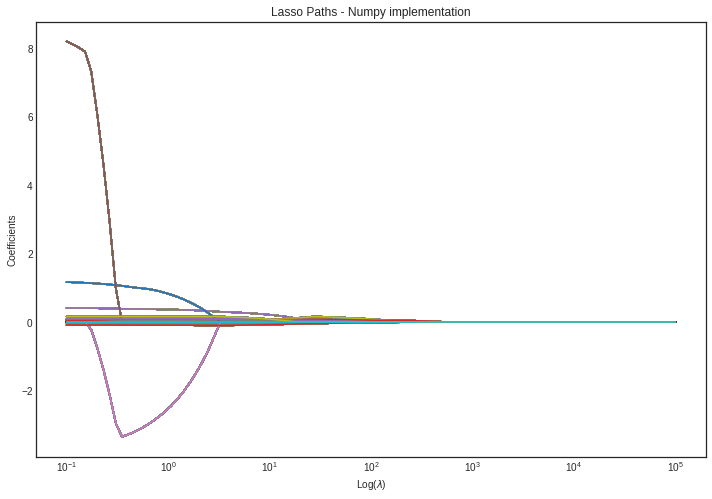

In [63]:
X = dataTrain[Xhead]
Y = dataTrain[Yhead]

%matplotlib inline
plt.style.use('seaborn-white')
model = LogisticRegression(penalty="l1", solver = 'liblinear', tol= 1e-4, max_iter = int(1e6))

lamda = np.logspace(0,6,100)/10
coefs_ = []
Y = Ytrain.values.reshape(-1,1)
for c in lamda:
    model.set_params(C=1/c)
    model.fit(Xtrain, Y.ravel())
    coefs_.append(model.coef_.ravel().copy())

coefs_ = np.array(coefs_)
n,_ = coefs_.shape
plt.figure(figsize = (12,8))
for i in range(n):
    plt.plot(lamda, coefs_)
plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')


zeros = []

# Loops through all the paths
for i in range(0, len(lamda)):

  # Loops through the values in the path
  for j in range(0,X.shape[1]):

    # When the path equals zero and is not in the list add it to the list
    if coefs_[i][j] == 0:
      if not headers[j] in zeros:
        zeros.append(headers[j])

# Reverses the list to represent a hierarchy of importance in descending order
zeros.reverse()
print(zeros)



Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99       168

    accuracy                           0.99       168
   macro avg       0.50      0.49      0.50       168
weighted avg       1.00      0.99      0.99       168


Confusion Matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-de

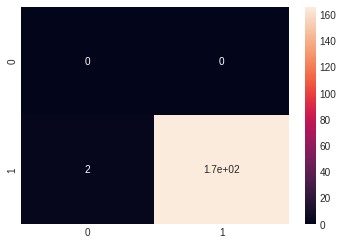

In [121]:
# fit the model to the training data
model = LogisticRegression(penalty="l1", solver = 'liblinear', tol= 1e-4, max_iter = int(1e6))
dropping = []
count = 0
# adds columns in index locations greater than the top two features
for i in zeros:
  if count >= 2:
    dropping.append(i)
  count +=1

X = dataTrain[Xhead]
Xtest = dataTest[Xhead]
# Drops the columns other than the two most important features
X = X.drop(columns = dropping)
Xtest = Xtest.drop(columns = dropping)
model.fit(X,Y)

# predict the labels of the test set
predictedY = model.predict(Xtest)
# print quality metrics
print('\nClassification Report:\n\n', classification_report(Ytest, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(Ytest, predictedY), annot = True)